In [1]:
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 36.4 MB/s 
     |████████████████████████████████| 831.4 MB 2.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.


In [2]:
!git clone https://github.com/felixboelter/Deep-Learning-Lab
%cd Deep-Learning-Lab/Assignment_3

Cloning into 'Deep-Learning-Lab'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 97 (delta 27), reused 84 (delta 16), pack-reused 0
Unpacking objects: 100% (97/97), done.
/content/Deep-Learning-Lab/Assignment_3


# Imports

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
from torchtext.legacy.data import Field
from torchtext.legacy.datasets import LanguageModelingDataset
from torchtext.legacy.data import BPTTIterator
from src.model import LSTMModel
from src.helper import counter, get_fables
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters

In [37]:
BATCH_SIZE = 64
EMBEDDING_DIM = 1024
HIDDEN_SIZE = 1024
LAYERS = 2
BPTT_LEN = 256
model_parameters = {
    'batch_size' : BATCH_SIZE,
    'embedding_dim': EMBEDDING_DIM,
    'hidden_size': HIDDEN_SIZE,
    'num_layers': LAYERS
}
bonus_path = os.path.join('data', "donaldtrump.txt")
book_path = os.path.join(os.path.join("data","books"), "AesopsFables.txt")

# Training Class

In [24]:
class Trainer():
    def __init__(self, model_parameters : dict, path : str, bptt_len : int, samples : list):
        self.samples = samples
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        _split_chars = lambda x: list(x) 
        self.train_field = Field(tokenize=_split_chars ,init_token ='<sos>',eos_token ='<eos>')
        train_dataset = LanguageModelingDataset(
            path = path,
            text_field=self.train_field
        )
        self.train_field.build_vocab(train_dataset)
        self.bptt_iterator = BPTTIterator(
            dataset= train_dataset,
            batch_size = model_parameters['batch_size'],
            bptt_len = bptt_len,
            shuffle = False
        )
        self.model = LSTMModel(**model_parameters, vocab_size = len(self.train_field.vocab)).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        
    def predict(self, model : LSTMModel, prompt : str,sequence_length : int, method : str = 'greedy') -> str:
        """
        The function takes in a model, a prompt, a sequence length, and a method. It then generates a
        sentence of the specified length using the specified method
        
        :param model: the model to use for prediction
        :type model: LSTMModel
        :param prompt: The prompt to start the sentence with
        :type prompt: str
        :param sequence_length: The length of the generated sequence
        :type sequence_length: int
        :param method: 'greedy' or 'random', defaults to greedy
        :type method: str (optional)
        :return: A string of the generated sentence
        """
        model.eval()
        generated_sentence=[]
        prompt = torch.tensor([self.train_field.vocab.stoi[t] for t in self.train_field.tokenize(prompt)]).long().to(self.device)
        hidden = None
        Softmax1D = nn.Softmax(dim=1)
        if method == 'greedy':
            out,hidden=model(prompt.view(-1,1),hidden)
            ix = torch.argmax(Softmax1D(out), dim=1)[len(prompt)-1]
            for i in range(sequence_length):
                out,hidden=model(ix.view(-1,1),hidden)
                ix = torch.argmax(Softmax1D(out), dim=1)
                generated_sentence.append(self.train_field.vocab.itos[ix])
        if method == 'random':
            out,hidden=model(prompt.view(-1,1),hidden)
            ix = torch.multinomial(Softmax1D(out),1)[len(prompt)-1]
            for i in range(sequence_length):
                out,hidden=model(ix.view(-1,1),hidden)
                ix = torch.multinomial(Softmax1D(out),1)
                generated_sentence.append(self.train_field.vocab.itos[ix])
        return ''.join(generated_sentence)

    def train_model(self, num_epochs : int) -> LSTMModel:
        """
        The function takes in the number of epochs and the model and trains the model for the given
        number of epochs
        
        :param num_epochs: Number of epochs to train for
        :return: The model is being returned.
        """
        # vocab_size = 
        loss_fn = nn.CrossEntropyLoss()
        total_steps = 0
        loss_plot =[]
        perp_plot=[]
        for epoch in range(1, num_epochs+1):
            cost = 0
            num_steps =0
            hidden=None
            print("___________________________________________________________________________")
            print(f"EPOCH: {epoch}")
            print(f'Total Steps: {total_steps}')
            print("___________________________________________________________________________")
            for batch in tqdm(self.bptt_iterator):
                self.model.train()
                self.optimizer.zero_grad()
                output, hidden = self.model(batch.text.to(self.device),hidden)
                hidden = (hidden[0].detach(), hidden[1].detach())
                targets = batch.target
                targets = targets.view(targets.shape[0]*targets.shape[1]).to(self.device)
                out = output.view(-1, self.model.vocab_size)
                loss = loss_fn(out,targets)
                cost += loss.item()
                num_steps += 1
                total_steps+=1
                loss.backward()
                self.optimizer.step()
            if epoch%10==0:
                self.model.eval()
                for prompt in self.samples:
                    print()
                    print('Greedy decoding')
                    gen_text = self.predict(self.model, prompt, 100)
                    print(f'Sample prompt: {prompt} | generated text: {gen_text}')
                    print()
                    print('Random decoding')
                    gen_text = self.predict(self.model, prompt, 100, method='random')
                    print(f'Sample prompt: {prompt} | generated text: {gen_text}')
                    print()

            perplexity = np.exp(cost/num_steps)
            loss_plot.append(cost/num_steps)
            perp_plot.append(perplexity)
            print(f"Training Loss: {cost/num_steps}, \n Training perplexity: {perplexity}")
        _, ax1 = plt.subplots()
        _, ax2 = plt.subplots()
        ax1.plot(loss_plot,'coral')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.title.set_text('Train Loss Plot')
        ax1.legend(["Train Loss"])
        ax2.plot(perp_plot,'deepskyblue')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.title.set_text('Train Perplexity Plot')
        ax2.legend(["Train Perplexity"])
        plt.show()
        return self.model

# Train the fable and the trump models

Training on data from: data/books/AesopsFables.txt
Fable Analysis
Word Count:  5033
Line Count:  5033
Char Count:  138881
Sentence Count:  1880
Vocab Count:  108
Count:  11
___________________________________________________________________________
EPOCH: 1
Total Steps: 0
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.96it/s]


Training Loss: 3.508342244408347, 
 Training perplexity: 33.3928646660972
___________________________________________________________________________
EPOCH: 2
Total Steps: 11
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


Training Loss: 2.777178244157271, 
 Training perplexity: 16.073601118460317
___________________________________________________________________________
EPOCH: 3
Total Steps: 22
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 2.413649862462824, 
 Training perplexity: 11.174672822728244
___________________________________________________________________________
EPOCH: 4
Total Steps: 33
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 2.173078927126798, 
 Training perplexity: 8.785291715053017
___________________________________________________________________________
EPOCH: 5
Total Steps: 44
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


Training Loss: 1.9946836233139038, 
 Training perplexity: 7.349877330178992
___________________________________________________________________________
EPOCH: 6
Total Steps: 55
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Training Loss: 1.8573272878473455, 
 Training perplexity: 6.406590895297073
___________________________________________________________________________
EPOCH: 7
Total Steps: 66
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.82it/s]


Training Loss: 1.7435639121315696, 
 Training perplexity: 5.717684479353002
___________________________________________________________________________
EPOCH: 8
Total Steps: 77
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Training Loss: 1.643246672370217, 
 Training perplexity: 5.1719338580971845
___________________________________________________________________________
EPOCH: 9
Total Steps: 88
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 1.558387203650041, 
 Training perplexity: 4.751152421391351
___________________________________________________________________________
EPOCH: 10
Total Steps: 99
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.90it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: the strong the strong the strong the strong the strong the strong the strong the strong the strong t

Random decoding
Sample prompt: Dogs like best to | generated text: that younte. Dether,<eos>one and that not onte vaily, but onner sureing the Crane before to mest; I all 


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: the strong the strong the strong the strong the strong the strong the strong the strong the strong t

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text:  “I will seom brent these us.<eos><eos><eos><eos><eos><eos>THE WOR'F ANT WA TRLOMA<eos><eos><eos>ONT Fall<eos>his gow that time he went his 


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: AND THE FOX<eos><eos><eos>A WOLF and the Fox and the Fox and the Fox and the Fox and the Fox and the Fox and the

Random decoding
Sample prompt: THE W

100%|██████████| 11/11 [00:05<00:00,  1.91it/s]


Training Loss: 1.419391317801042, 
 Training perplexity: 4.134603014918184
___________________________________________________________________________
EPOCH: 12
Total Steps: 121
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.91it/s]


Training Loss: 1.357061136852611, 
 Training perplexity: 3.8847597319632077
___________________________________________________________________________
EPOCH: 13
Total Steps: 132
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.92it/s]


Training Loss: 1.308378978209062, 
 Training perplexity: 3.7001707906095618
___________________________________________________________________________
EPOCH: 14
Total Steps: 143
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.91it/s]


Training Loss: 1.2572523572228171, 
 Training perplexity: 3.5157481839559686
___________________________________________________________________________
EPOCH: 15
Total Steps: 154
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.91it/s]


Training Loss: 1.2077831788496538, 
 Training perplexity: 3.346058810766518
___________________________________________________________________________
EPOCH: 16
Total Steps: 165
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 1.1698520617051558, 
 Training perplexity: 3.221516017687662
___________________________________________________________________________
EPOCH: 17
Total Steps: 176
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 1.127450401132757, 
 Training perplexity: 3.0877738708599978
___________________________________________________________________________
EPOCH: 18
Total Steps: 187
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 1.0917246666821567, 
 Training perplexity: 2.9794081299558886
___________________________________________________________________________
EPOCH: 19
Total Steps: 198
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 1.0562111681157893, 
 Training perplexity: 2.8754557059784647
___________________________________________________________________________
EPOCH: 20
Total Steps: 209
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: her charges of the work of the same carefully against the work of a little Fox who had no companion 

Random decoding
Sample prompt: Dogs like best to | generated text: first the foot. The Foxes good frightened head one good a<eos>twightin,” he had generowned the other Fwa


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: heart the Fox who had no companion when he was not a good price.<eos><eos>“What good let her good found a fe

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: feven her against him,<eos>but in sight,” said he;, and he felf gound.<eos><eos><eos><eos><eos>THE HEUND AND EACE<eos><eos><eos>THE GODE


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A DOG once had a Fox was a part of the Foxes                                                      

Random decoding
Sample prompt: THE W

100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Training Loss: 0.9873887571421537, 
 Training perplexity: 2.6842161727847644
___________________________________________________________________________
EPOCH: 22
Total Steps: 231
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Training Loss: 0.9410923448475924, 
 Training perplexity: 2.5627793287047975
___________________________________________________________________________
EPOCH: 23
Total Steps: 242
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.8962021524255926, 
 Training perplexity: 2.4502796292353857
___________________________________________________________________________
EPOCH: 24
Total Steps: 253
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


Training Loss: 0.8587951280853965, 
 Training perplexity: 2.3603151023870335
___________________________________________________________________________
EPOCH: 25
Total Steps: 264
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.8258946646343578, 
 Training perplexity: 2.2839231968592597
___________________________________________________________________________
EPOCH: 26
Total Steps: 275
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.7945470268076117, 
 Training perplexity: 2.213438141546818
___________________________________________________________________________
EPOCH: 27
Total Steps: 286
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


Training Loss: 0.7577912319790233, 
 Training perplexity: 2.1335584764800486
___________________________________________________________________________
EPOCH: 28
Total Steps: 297
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


Training Loss: 0.7117971236055548, 
 Training perplexity: 2.037649878862861
___________________________________________________________________________
EPOCH: 29
Total Steps: 308
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.91it/s]


Training Loss: 0.6716824228113348, 
 Training perplexity: 1.957527941414482
___________________________________________________________________________
EPOCH: 30
Total Steps: 319
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: see what it was.<eos><eos>“Oh, I did not know when you have to save you to stop that you have a good dinner.

Random decoding
Sample prompt: Dogs like best to | generated text: derive caught down to the<eos>high more<eos>beautiful crying that whoever, but it is get outs,<eos>eared awake t


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: to call upon him. Alate your standing through the strong.”<eos><eos>“I am strong and stood for you.”<eos><eos>“It is

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text:  Not her came to inquite a dinner captive, might be turned to<eos>incum for yoe.” But nivery ax, twentay


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A DOG once made a company of a thirsty wise caught in the water and stood under the stronger came 

Random decoding
Sample prompt: THE WOMAN AND

100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


Training Loss: 0.6331561045213179, 
 Training perplexity: 1.8835458757841366
___________________________________________________________________________
EPOCH: 32
Total Steps: 341
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


Training Loss: 0.6037972298535433, 
 Training perplexity: 1.8290509574634115
___________________________________________________________________________
EPOCH: 33
Total Steps: 352
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.91it/s]


Training Loss: 0.5545987324281172, 
 Training perplexity: 1.7412421405658882
___________________________________________________________________________
EPOCH: 34
Total Steps: 363
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.5023928609761324, 
 Training perplexity: 1.6526711553670639
___________________________________________________________________________
EPOCH: 35
Total Steps: 374
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.4695057543841275, 
 Training perplexity: 1.5992035984920234
___________________________________________________________________________
EPOCH: 36
Total Steps: 385
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.46129306879910553, 
 Training perplexity: 1.5861236265181167
___________________________________________________________________________
EPOCH: 37
Total Steps: 396
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.4404134750366211, 
 Training perplexity: 1.5533493569303265
___________________________________________________________________________
EPOCH: 38
Total Steps: 407
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.40163053436712787, 
 Training perplexity: 1.4942591532729286
___________________________________________________________________________
EPOCH: 39
Total Steps: 418
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.3745435286651958, 
 Training perplexity: 1.4543274043074081
___________________________________________________________________________
EPOCH: 40
Total Steps: 429
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: be real. Dashing down to the pattry that<eos>the proposed the Frog from the pond came to the lattle, his

Random decoding
Sample prompt: Dogs like best to | generated text: elate.<eos><eos>Please check, a try a latter that the Moon made him at last no<eos>  long feel by a lattlem, tha


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text:  they came to the latter, the<eos>Crow opened her mouth to say the Frog from the contest of the<eos>animally

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text:  he rain.<eos><eos>5. The leaf Cat came apoly to you help proceed to say: “I be not to look<eos>to my eat a hol!


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A PERTAIN man had the hand on a Lion’s Skin                   19<eos>    The Wolf and the Shepherd    

Random decoding
Sample prompt: THE WOMAN AND

100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.3038220541043715, 
 Training perplexity: 1.355027912979518
___________________________________________________________________________
EPOCH: 42
Total Steps: 451
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.2867490879514001, 
 Training perplexity: 1.3320899341257806
___________________________________________________________________________
EPOCH: 43
Total Steps: 462
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Training Loss: 0.28380563855171204, 
 Training perplexity: 1.3281747596944833
___________________________________________________________________________
EPOCH: 44
Total Steps: 473
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Training Loss: 0.25537326390093024, 
 Training perplexity: 1.290943393520073
___________________________________________________________________________
EPOCH: 45
Total Steps: 484
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Training Loss: 0.22225111045620657, 
 Training perplexity: 1.248884946561127
___________________________________________________________________________
EPOCH: 46
Total Steps: 495
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Training Loss: 0.2091653821143237, 
 Training perplexity: 1.2326488397452804
___________________________________________________________________________
EPOCH: 47
Total Steps: 506
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Training Loss: 0.20736240663311697, 
 Training perplexity: 1.2304284064052173
___________________________________________________________________________
EPOCH: 48
Total Steps: 517
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.19649037312377582, 
 Training perplexity: 1.2171236037235118
___________________________________________________________________________
EPOCH: 49
Total Steps: 528
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Training Loss: 0.17305733398957687, 
 Training perplexity: 1.188934269474959
___________________________________________________________________________
EPOCH: 50
Total Steps: 539
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: earnest and many assisted the Horse, and will come up and said, “Thank<eos>you must expect to suffer by 

Random decoding
Sample prompt: Dogs like best to | generated text: provide a replarch for ene to do. Anow use it means of<eos>why I am courty and restore, he lost in the<eos>s


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in the world. Let others choose when the Fox was abroad, the Horse asked a Moth<eos>to let a bird go. Wh

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: as long<eos>enough. You must located in the<eos>  Are and hole as see a dog,<eos>and all the first blew a tree, 


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A THRIFTY Woman kept a Hen to come and help her eat up the forest.<eos><eos>As they fell groaning the Hawk

Random decoding
Sample prompt: THE WOMAN AND HER

100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Training Loss: 0.15600216388702393, 
 Training perplexity: 1.1688287323004596
___________________________________________________________________________
EPOCH: 52
Total Steps: 561
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Training Loss: 0.13591341809792953, 
 Training perplexity: 1.1455827025714824
___________________________________________________________________________
EPOCH: 53
Total Steps: 572
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Training Loss: 0.11354356733235446, 
 Training perplexity: 1.120240693727845
___________________________________________________________________________
EPOCH: 54
Total Steps: 583
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.09808321500366385, 
 Training perplexity: 1.1030545719796812
___________________________________________________________________________
EPOCH: 55
Total Steps: 594
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Training Loss: 0.08203717625953934, 
 Training perplexity: 1.0854961637665532
___________________________________________________________________________
EPOCH: 56
Total Steps: 605
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.06834347783164545, 
 Training perplexity: 1.070733018380484
___________________________________________________________________________
EPOCH: 57
Total Steps: 616
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.059456522491845215, 
 Training perplexity: 1.061259619052734
___________________________________________________________________________
EPOCH: 58
Total Steps: 627
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.051107781515880066, 
 Training perplexity: 1.052436320352398
___________________________________________________________________________
EPOCH: 59
Total Steps: 638
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.04737241633913734, 
 Training perplexity: 1.0485124195343503
___________________________________________________________________________
EPOCH: 60
Total Steps: 649
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.87it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: eat at home, and he<eos>peased to the ice.<eos><eos>No great harm was done; the Fox could easily remedy it. It h

Random decoding
Sample prompt: Dogs like best to | generated text: eat attempted trademark that the<eos>Poor Mannerstopped downling in the well. “I will return the cock, s


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: <eos><eos>They renewed the Wolf took up the head Frog, and<eos>the Horse was fed with chaff and whatever he migh

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in perfect meat in the<eos>world.”<eos><eos>“And so would we,” said the hens. “Nothing can do us good if it is n


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A WOMAN had a Hen that laid an egg every day. The eggs were large, and<eos>sold for a good price. The 

Random decoding
Sample prompt: THE WOMAN

100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


Training Loss: 0.03873975642702796, 
 Training perplexity: 1.0394999252714885
___________________________________________________________________________
EPOCH: 62
Total Steps: 671
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


Training Loss: 0.033054154704917564, 
 Training perplexity: 1.0336065123813662
___________________________________________________________________________
EPOCH: 63
Total Steps: 682
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


Training Loss: 0.03115555406971411, 
 Training perplexity: 1.0316459681346133
___________________________________________________________________________
EPOCH: 64
Total Steps: 693
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.029927278276194225, 
 Training perplexity: 1.0303796002481913
___________________________________________________________________________
EPOCH: 65
Total Steps: 704
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


Training Loss: 0.029017436572096565, 
 Training perplexity: 1.0294425442677813
___________________________________________________________________________
EPOCH: 66
Total Steps: 715
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.027289053255861454, 
 Training perplexity: 1.0276648096951877
___________________________________________________________________________
EPOCH: 67
Total Steps: 726
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.025603933767838913, 
 Training perplexity: 1.025934529970703
___________________________________________________________________________
EPOCH: 68
Total Steps: 737
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.02528189512139017, 
 Training perplexity: 1.0256041925968815
___________________________________________________________________________
EPOCH: 69
Total Steps: 748
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.0259749579497359, 
 Training perplexity: 1.026315247113631
___________________________________________________________________________
EPOCH: 70
Total Steps: 759
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: advise.<eos><eos>The Man looked up gratefully, but, growing faint with sudden heat, he<eos>quickly flung aside h

Random decoding
Sample prompt: Dogs like best to | generated text: adge.<eos><eos>He who saw his whick haw are grain and was sure to and amused himself beside it, in a quiet, 


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text:  in all abore, dispecided with him.<eos><eos><eos><eos><eos>THE DOG AND HIS SHADOW<eos><eos><eos>A DOG had stolen a piece of meat ou

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text:  if you came against the air in head wanted. “Oh, Mother,” they<eos>creatures had no protection from suc


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A THRIFTY Woman kept a Hen that could be depended on to lay an egg<eos>every morning. The watchful Wom

Random decoding
Sample p

100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.02584523724561388, 
 Training perplexity: 1.026182121411891
___________________________________________________________________________
EPOCH: 72
Total Steps: 781
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.02514085021208633, 
 Training perplexity: 1.0254595465475893
___________________________________________________________________________
EPOCH: 73
Total Steps: 792
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


Training Loss: 0.023857568136670372, 
 Training perplexity: 1.0241444367013652
___________________________________________________________________________
EPOCH: 74
Total Steps: 803
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.021806363693692467, 
 Training perplexity: 1.0220458601231557
___________________________________________________________________________
EPOCH: 75
Total Steps: 814
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.019778105006976562, 
 Training perplexity: 1.019974987571695
___________________________________________________________________________
EPOCH: 76
Total Steps: 825
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.01869116435674104, 
 Training perplexity: 1.018866937596851
___________________________________________________________________________
EPOCH: 77
Total Steps: 836
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


Training Loss: 0.016825695522129536, 
 Training perplexity: 1.0169680447914973
___________________________________________________________________________
EPOCH: 78
Total Steps: 847
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


Training Loss: 0.016264133409342983, 
 Training perplexity: 1.0163971143890729
___________________________________________________________________________
EPOCH: 79
Total Steps: 858
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.015260969965972683, 
 Training perplexity: 1.015378013207959
___________________________________________________________________________
EPOCH: 80
Total Steps: 869
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: eat at home,<eos>and his wood as necessary in replacement copy in doing and wisping him. “If you really 

Random decoding
Sample prompt: Dogs like best to | generated text: eat at home, and<eos>he was sold to a farmer, who made him drag heavy loads.<eos><eos>Since he had not been trai


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in the Introduction.<eos><eos>No occasion has been found to change in this edition the style of<eos>presentation

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in the IS<eos>That so life of Nermins, the Cock thought he was a mousect, and are<eos>redistributing Project


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A THRIFTY Woman kept a Hen that could be depended on to lay an egg<eos>every morning. The watchful Wom

Random decoding
Sample prompt: THE WOMAN AND

100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.01372996387495236, 
 Training perplexity: 1.0138246526906767
___________________________________________________________________________
EPOCH: 82
Total Steps: 891
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.01264099378816106, 
 Training perplexity: 1.0127212288774496
___________________________________________________________________________
EPOCH: 83
Total Steps: 902
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.01306751590560783, 
 Training perplexity: 1.0131532690111602
___________________________________________________________________________
EPOCH: 84
Total Steps: 913
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.012879453345455906, 
 Training perplexity: 1.0129627507288033
___________________________________________________________________________
EPOCH: 85
Total Steps: 924
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.011536436240104113, 
 Training perplexity: 1.0116032375565585
___________________________________________________________________________
EPOCH: 86
Total Steps: 935
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.0102853103202175, 
 Training perplexity: 1.0103383859347257
___________________________________________________________________________
EPOCH: 87
Total Steps: 946
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.009667126927524805, 
 Training perplexity: 1.009714004534531
___________________________________________________________________________
EPOCH: 88
Total Steps: 957
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.009548871269957586, 
 Training perplexity: 1.0095946072008142
___________________________________________________________________________
EPOCH: 89
Total Steps: 968
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.010110962627963587, 
 Training perplexity: 1.0101622511235375
___________________________________________________________________________
EPOCH: 90
Total Steps: 979
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: eat at home, and he went<eos>trick and again, and put the poor broken Tree.<eos><eos>“O Reed,” said the Tree, “h

Random decoding
Sample prompt: Dogs like best to | generated text: lay that the Fox could never reach her, in<eos>her nest high in the pine tree, flew away with the little


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text:  if you will be as well<eos>as it will not to let you go; for no death is too bad for one who is ready t

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in the great field. The<eos>Ants were busy all the time gathering a store of grain to lay by for<eos>winter 


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A THRIFTY Woman kept a Hen that could be depended on to lay an egg<eos>every morning. The watchful Wom

Random decoding
Sample prompt: THE WOMAN AND HER HEN

100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.011015584438361904, 
 Training perplexity: 1.0110764793810099
___________________________________________________________________________
EPOCH: 92
Total Steps: 1001
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.011052487968382511, 
 Training perplexity: 1.0111137923607059
___________________________________________________________________________
EPOCH: 93
Total Steps: 1012
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.012178348885341124, 
 Training perplexity: 1.0122528069278007
___________________________________________________________________________
EPOCH: 94
Total Steps: 1023
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.012556520714001223, 
 Training perplexity: 1.0126356848151152
___________________________________________________________________________
EPOCH: 95
Total Steps: 1034
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.013426354832269928, 
 Training perplexity: 1.01351689308009
___________________________________________________________________________
EPOCH: 96
Total Steps: 1045
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 0.014626885764300823, 
 Training perplexity: 1.0147343821307728
___________________________________________________________________________
EPOCH: 97
Total Steps: 1056
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.014507814987816593, 
 Training perplexity: 1.0146135641130576
___________________________________________________________________________
EPOCH: 98
Total Steps: 1067
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Training Loss: 0.012411546300758015, 
 Training perplexity: 1.012488889191942
___________________________________________________________________________
EPOCH: 99
Total Steps: 1078
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Training Loss: 0.009825472423637455, 
 Training perplexity: 1.0098739008586082
___________________________________________________________________________
EPOCH: 100
Total Steps: 1089
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: eat at home,<eos>and his vines were presently destroyed. The simple<eos>fellow learned, when it was too late

Random decoding
Sample prompt: Dogs like best to | generated text: eat at home,<eos>and finding that her high wis taken by stated that it was<eos>subssight to eat it up. Again


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text:  if you will be as desperite to instruct and to be instructed,<eos>he traveled through many countries, a

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text:  if you will be<eos>as to be well.”<eos><eos>“Alas,” said the Father, “if you wish for fine weather, and your si


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A THRIFTY Woman kept a Hen that could be depended on to lay an egg<eos>every morning. The watchful Wom

Random decoding
Sample prompt: THE WOMAN AND HER

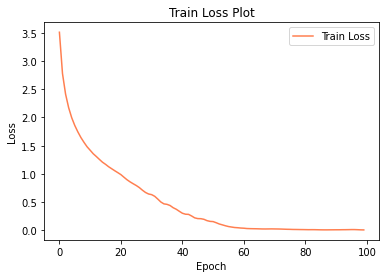

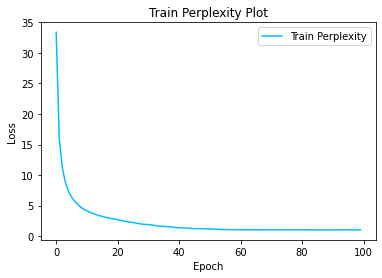

In [25]:
fable_samples = ['Dogs like best to', 'THERE were once some Frogs who lived together', 'THE WOMAN AND HER HEN']
get_fables()
PATH = book_path
trainer = Trainer(model_parameters = model_parameters, path = PATH, bptt_len = BPTT_LEN, samples = fable_samples)
print(f"Training on data from: {PATH}")
print("Fable Analysis")
counter(PATH)
print("Vocab Count: ", len(trainer.train_field.vocab))
print("Count: ", len(trainer.bptt_iterator))
fable_model = trainer.train_model(num_epochs=100)
torch.save(fable_model.state_dict(), 'fable_model.pt')

Word Count:  1785
Line Count:  1785
Char Count:  212573
Sentence Count:  4852
Vocab Count:  86
Count:  16
___________________________________________________________________________
EPOCH: 1
Total Steps: 0
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


Training Loss: 3.2578169256448746, 
 Training perplexity: 25.992731094493536
___________________________________________________________________________
EPOCH: 2
Total Steps: 16
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


Training Loss: 2.4094294607639313, 
 Training perplexity: 11.12761059517039
___________________________________________________________________________
EPOCH: 3
Total Steps: 32
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 2.009411871433258, 
 Training perplexity: 7.4589292476944316
___________________________________________________________________________
EPOCH: 4
Total Steps: 48
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 1.7257963865995407, 
 Training perplexity: 5.616992546522555
___________________________________________________________________________
EPOCH: 5
Total Steps: 64
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 1.5247340947389603, 
 Training perplexity: 4.5939218588931885
___________________________________________________________________________
EPOCH: 6
Total Steps: 80
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 1.3823185488581657, 
 Training perplexity: 3.984128323263662
___________________________________________________________________________
EPOCH: 7
Total Steps: 96
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


Training Loss: 1.2769896686077118, 
 Training perplexity: 3.5858289283018823
___________________________________________________________________________
EPOCH: 8
Total Steps: 112
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 1.1995025724172592, 
 Training perplexity: 3.3184658156883926
___________________________________________________________________________
EPOCH: 9
Total Steps: 128
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.90it/s]


Training Loss: 1.1358468160033226, 
 Training perplexity: 3.1138092502724577
___________________________________________________________________________
EPOCH: 10
Total Steps: 144
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.89it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  people that we have to the morning that we have the states of the morning that we want to get the f

Random decoding
Sample prompt: Good morning America | generated text:  and he was wrong power religious can cover one, we will end from the subpracess very sincely, the l


Greedy decoding
Sample prompt: Very good | generated text: and we will be the first that we have the states of the morning that we want to get the father we wi

Random decoding
Sample prompt: Very good | generated text:  I’m renoight from the second watch the very, woke North God 1n, $0,000, U87. It’s a vote the are ar


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:01:05)<eos>We have the states of the morning that we want to get the father we will be the first tha

Random decoding
Sample prompt: Donald Trump: | generated text: (447:01)<eos>Cour you that anyway, I all happening in to me, “on who assuhrouss, “NoV, that’d again

100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 1.0281106904149055, 
 Training perplexity: 2.7957787502114844
___________________________________________________________________________
EPOCH: 12
Total Steps: 176
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.9814706332981586, 
 Training perplexity: 2.6683775627059982
___________________________________________________________________________
EPOCH: 13
Total Steps: 192
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.9433689564466476, 
 Training perplexity: 2.568620428285025
___________________________________________________________________________
EPOCH: 14
Total Steps: 208
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.9153436496853828, 
 Training perplexity: 2.4976334153800357
___________________________________________________________________________
EPOCH: 15
Total Steps: 224
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.8782270848751068, 
 Training perplexity: 2.40662917262868
___________________________________________________________________________
EPOCH: 16
Total Steps: 240
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.8397681787610054, 
 Training perplexity: 2.3158300559557983
___________________________________________________________________________
EPOCH: 17
Total Steps: 256
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.810456495732069, 
 Training perplexity: 2.248934381333039
___________________________________________________________________________
EPOCH: 18
Total Steps: 272
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.7744087092578411, 
 Training perplexity: 2.1693090555252152
___________________________________________________________________________
EPOCH: 19
Total Steps: 288
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.7438667565584183, 
 Training perplexity: 2.1040556761175755
___________________________________________________________________________
EPOCH: 20
Total Steps: 304
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]



Greedy decoding
Sample prompt: Good morning America | generated text: were from the most in the world. And the next morning and we will make America great again. Thank yo

Random decoding
Sample prompt: Good morning America | generated text: safe, confidence, from I mean, it’s true. Where’s Peterre’s going an ofther strents down now. They d


Greedy decoding
Sample prompt: Very good | generated text: reasons we’re going to win four more years of President Donald Trump in the history of our country a

Random decoding
Sample prompt: Very good | generated text: rating, and strung, your drugs and all the insleepy, just mic how the great America and plague on th


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:01:08)<eos>I was so badly, they were treated by the way, we’re going to win four more years of Presi

Random decoding
Sample prompt: Donald Trump: | generated text: (17:00)<eos>She protects want to do it. Because of univerers. You never happened if I am safety goi

100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Training Loss: 0.6806976646184921, 
 Training perplexity: 1.975255317375785
___________________________________________________________________________
EPOCH: 22
Total Steps: 336
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.6546691060066223, 
 Training perplexity: 1.9245056046620739
___________________________________________________________________________
EPOCH: 23
Total Steps: 352
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.62198306620121, 
 Training perplexity: 1.8626180767991363
___________________________________________________________________________
EPOCH: 24
Total Steps: 368
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.590885829180479, 
 Training perplexity: 1.805587148975347
___________________________________________________________________________
EPOCH: 25
Total Steps: 384
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.560091707855463, 
 Training perplexity: 1.7508330580788138
___________________________________________________________________________
EPOCH: 26
Total Steps: 400
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Training Loss: 0.5390584357082844, 
 Training perplexity: 1.714391891817613
___________________________________________________________________________
EPOCH: 27
Total Steps: 416
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.5118969734758139, 
 Training perplexity: 1.6684532063498765
___________________________________________________________________________
EPOCH: 28
Total Steps: 432
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.47373875603079796, 
 Training perplexity: 1.6059873777026048
___________________________________________________________________________
EPOCH: 29
Total Steps: 448
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.4455697275698185, 
 Training perplexity: 1.5613795034271363
___________________________________________________________________________
EPOCH: 30
Total Steps: 464
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.85it/s]



Greedy decoding
Sample prompt: Good morning America | generated text: into the manufacturing superpower of the world, all the way down. But he’s a great group of people a

Random decoding
Sample prompt: Good morning America | generated text:  we are off and a half. I’ll never have been will leaving to the United States will be all achoised 


Greedy decoding
Sample prompt: Very good | generated text:  I want to talk about it. I don’t know. I don’t know. I don’t know. I don’t know. I don’t know. I do

Random decoding
Sample prompt: Very good | generated text: in jais that fracking? What a good guy. I never even here. I haday that always does that all happene


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:21:03)<eos>… all of them, all of them. I don’t want to give him the money at that bad things are hap

Random decoding
Sample prompt: Donald Trump: | generated text: Young a job you all despred available. I’m place it was will wipe out that walk off. They think her

100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.4107594005763531, 
 Training perplexity: 1.5079624980001285
___________________________________________________________________________
EPOCH: 32
Total Steps: 496
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.3806584980338812, 
 Training perplexity: 1.4632478180686164
___________________________________________________________________________
EPOCH: 33
Total Steps: 512
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.34832954593002796, 
 Training perplexity: 1.4166990402241273
___________________________________________________________________________
EPOCH: 34
Total Steps: 528
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.32185858860611916, 
 Training perplexity: 1.3796896583239369
___________________________________________________________________________
EPOCH: 35
Total Steps: 544
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.300707483664155, 
 Training perplexity: 1.3508141485354919
___________________________________________________________________________
EPOCH: 36
Total Steps: 560
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.28182265162467957, 
 Training perplexity: 1.3255436161330274
___________________________________________________________________________
EPOCH: 37
Total Steps: 576
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.2580297365784645, 
 Training perplexity: 1.2943773084043517
___________________________________________________________________________
EPOCH: 38
Total Steps: 592
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.24233974236994982, 
 Training perplexity: 1.274227028196186
___________________________________________________________________________
EPOCH: 39
Total Steps: 608
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.22786302212625742, 
 Training perplexity: 1.2559132813186147
___________________________________________________________________________
EPOCH: 40
Total Steps: 624
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]



Greedy decoding
Sample prompt: Good morning America | generated text: s by far the highest. And we will end our reliance on China once and for all. Nobody knew it was str

Random decoding
Sample prompt: Good morning America | generated text:  blood and traveled big did with farmers, I delligive it the worst Cornat and Coast Guard, 14 years 


Greedy decoding
Sample prompt: Very good | generated text: places with that for 52 years, I got off the plane, I meant Social Security as well all of them. We 

Random decoding
Sample prompt: Very good | generated text: open up. Look at him on that if I didn’t supposed to pro-American values. This will not be the only 


Greedy decoding
Sample prompt: Donald Trump: | generated text: (23:54)<eos>In one order to restore the ones dealing with Russia. What a job she did. Ronna McDaniel. Wh

Random decoding
Sample prompt: Donald Trump: | generated text: (23:05)<eos>But on the problem itself. And he never come back and you could possibly imagine. This 

100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.19096513744443655, 
 Training perplexity: 1.2104172531069803
___________________________________________________________________________
EPOCH: 42
Total Steps: 656
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.1789677869528532, 
 Training perplexity: 1.1959822173158001
___________________________________________________________________________
EPOCH: 43
Total Steps: 672
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.15867909509688616, 
 Training perplexity: 1.1719617980427206
___________________________________________________________________________
EPOCH: 44
Total Steps: 688
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.1409433730877936, 
 Training perplexity: 1.151359448208339
___________________________________________________________________________
EPOCH: 45
Total Steps: 704
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.12725271470844746, 
 Training perplexity: 1.1357039906217028
___________________________________________________________________________
EPOCH: 46
Total Steps: 720
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.11732342140749097, 
 Training perplexity: 1.124483052777251
___________________________________________________________________________
EPOCH: 47
Total Steps: 736
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


Training Loss: 0.10840653395280242, 
 Training perplexity: 1.1145007356917411
___________________________________________________________________________
EPOCH: 48
Total Steps: 752
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.09654319705441594, 
 Training perplexity: 1.1013571555012285
___________________________________________________________________________
EPOCH: 49
Total Steps: 768
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.08759342366829515, 
 Training perplexity: 1.0915442357462208
___________________________________________________________________________
EPOCH: 50
Total Steps: 784
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  blood and treasure in endless foreign wars in countries that most of you have never even heard of, 

Random decoding
Sample prompt: Good morning America | generated text:  blood and treasure in endless foreign, ribs the care they know I have a great … She’s just a beauti


Greedy decoding
Sample prompt: Very good | generated text:  I’ll tell you, they understand the disease. It’s a terrible thing. Should never have been allowed t

Random decoding
Sample prompt: Very good | generated text: <eos><eos>Donald Trump: (02:05:35)<eos>This election comes down to a simple choice, you know what I kid Pennsylv


Greedy decoding
Sample prompt: Donald Trump: | generated text: (02:21:34)<eos>State GOP Chair, Laura Cox. Laura? Good job. Are we going to win? Otherwise, we will fire

Random decoding
Sample prompt: Donald Trump: | generated text: (02:17:39)<eos>Thank you very much.<eos><eos>Crowd: (01:38:24)<eos>We love you. We love

100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.0691246862988919, 
 Training perplexity: 1.071569810892744
___________________________________________________________________________
EPOCH: 52
Total Steps: 816
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.059541318099945784, 
 Training perplexity: 1.061349613022977
___________________________________________________________________________
EPOCH: 53
Total Steps: 832
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.05194299388676882, 
 Training perplexity: 1.0533156953680556
___________________________________________________________________________
EPOCH: 54
Total Steps: 848
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.04671594360843301, 
 Training perplexity: 1.0478243256052828
___________________________________________________________________________
EPOCH: 55
Total Steps: 864
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.04117722134105861, 
 Training perplexity: 1.0420367603347105
___________________________________________________________________________
EPOCH: 56
Total Steps: 880
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.03727008099667728, 
 Training perplexity: 1.037973319853485
___________________________________________________________________________
EPOCH: 57
Total Steps: 896
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.03325510828290135, 
 Training perplexity: 1.0338142401793797
___________________________________________________________________________
EPOCH: 58
Total Steps: 912
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.03014323429670185, 
 Training perplexity: 1.030602140954911
___________________________________________________________________________
EPOCH: 59
Total Steps: 928
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.026480044587515295, 
 Training perplexity: 1.0268337561660712
___________________________________________________________________________
EPOCH: 60
Total Steps: 944
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  blood and treasure in endless ridiculous foreign wars in countries you’ve never even heard of for t

Random decoding
Sample prompt: Good morning America | generated text:  blood and treasure in endless foreign wars in countries that most of you have never even heard of, 


Greedy decoding
Sample prompt: Very good | generated text: Ronatives leave. Can you hear it back there by the way?<eos><eos>Audience: (03:33)<eos>No!<eos><eos>President Donald J. 

Random decoding
Sample prompt: Very good | generated text: like that.<eos>President Donald J. Trump: (01:10:03)<eos>For years, you had a president who apologized for A


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:29:31)<eos>It’s really amazing. And I think we’re winning. I think they’re willing to spend thousand

Random decoding
Sample prompt: Donald Trump: | generated text: (02:21:32)<eos>Thank you very much.<eos><eos>Crowd: (38:06)<eos>Everyon

100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.020102631067857146, 
 Training perplexity: 1.0203060497528555
___________________________________________________________________________
EPOCH: 62
Total Steps: 976
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.017792362603358924, 
 Training perplexity: 1.017951589626678
___________________________________________________________________________
EPOCH: 63
Total Steps: 992
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.015489634301047772, 
 Training perplexity: 1.0156102204939497
___________________________________________________________________________
EPOCH: 64
Total Steps: 1008
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.014666255156043917, 
 Training perplexity: 1.0147743323925817
___________________________________________________________________________
EPOCH: 65
Total Steps: 1024
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.013846954505424947, 
 Training perplexity: 1.0139432676142657
___________________________________________________________________________
EPOCH: 66
Total Steps: 1040
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.013380645017605275, 
 Training perplexity: 1.0134705664695463
___________________________________________________________________________
EPOCH: 67
Total Steps: 1056
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.013257571961730719, 
 Training perplexity: 1.0133458432250846
___________________________________________________________________________
EPOCH: 68
Total Steps: 1072
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.01344575872644782, 
 Training perplexity: 1.0135365594454322
___________________________________________________________________________
EPOCH: 69
Total Steps: 1088
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.01261363277444616, 
 Training perplexity: 1.0126935201770877
___________________________________________________________________________
EPOCH: 70
Total Steps: 1104
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.89it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  blood and treasure in endless foreign, ridiculous wars. Countries you’ve never even heard of. In 20

Random decoding
Sample prompt: Good morning America | generated text:  blood and treasure in endless foreign, ridiculous wars. Countries you’ve never even heard of. In 20


Greedy decoding
Sample prompt: Very good | generated text: relationships in different parts of the world. In some we help. We don’t have to, though. Now we don

Random decoding
Sample prompt: Very good | generated text:  Oh, let them people are tough. You saw that for 55 years, this is the turn a you go into one thing 


Greedy decoding
Sample prompt: Donald Trump: | generated text: (25:15)<eos>And you know, I don’t have the luxury of staying in a basement. I’m president of the United 

Random decoding
Sample prompt: Donald Trump: | generated text: (02:21:53)<eos>No, I think we’re going to have a tremendous victory in all of these States they’re 

100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.010111163428518921, 
 Training perplexity: 1.010162453964699
___________________________________________________________________________
EPOCH: 72
Total Steps: 1136
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.008856766973622143, 
 Training perplexity: 1.008896104181966
___________________________________________________________________________
EPOCH: 73
Total Steps: 1152
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


Training Loss: 0.007930648047477007, 
 Training perplexity: 1.0079621789350444
___________________________________________________________________________
EPOCH: 74
Total Steps: 1168
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.007190521893789992, 
 Training perplexity: 1.0072164357705395
___________________________________________________________________________
EPOCH: 75
Total Steps: 1184
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


Training Loss: 0.006615919468458742, 
 Training perplexity: 1.0066378530071611
___________________________________________________________________________
EPOCH: 76
Total Steps: 1200
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.006336192338494584, 
 Training perplexity: 1.0063563084692846
___________________________________________________________________________
EPOCH: 77
Total Steps: 1216
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


Training Loss: 0.006018774030962959, 
 Training perplexity: 1.0060369232451167
___________________________________________________________________________
EPOCH: 78
Total Steps: 1232
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.005674635962350294, 
 Training perplexity: 1.0056907672075497
___________________________________________________________________________
EPOCH: 79
Total Steps: 1248
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.0053970458975527436, 
 Training perplexity: 1.0054116361861059
___________________________________________________________________________
EPOCH: 80
Total Steps: 1264
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.89it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  blood and treasure in endless foreign wars in countries that most of you have never even heard of, 

Random decoding
Sample prompt: Good morning America | generated text:  blood and treasure in endless foreign, ridiculous wars. Countries you’ve never even heard of. In 20


Greedy decoding
Sample prompt: Very good | generated text: relationships in different parts of the world. In some we help. We don’t have to, though. Now we don

Random decoding
Sample prompt: Very good | generated text: news for you. 99.99, okay, you know what that means? That means you’re in good shape. That’s what th


Greedy decoding
Sample prompt: Donald Trump: | generated text: (14:17)<eos>The doctor told me, “Sir, your son has tested positive.” I see him like 12 seconds later, “D

Random decoding
Sample prompt: Donald Trump: | generated text: (15:12)<eos>Can you imagine? You know, I have a lot of my kids here tonight. Could you imagine if m

100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.004778042115503922, 
 Training perplexity: 1.0047894751606705
___________________________________________________________________________
EPOCH: 82
Total Steps: 1296
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.004659781901864335, 
 Training perplexity: 1.004670655568629
___________________________________________________________________________
EPOCH: 83
Total Steps: 1312
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Training Loss: 0.004477897979086265, 
 Training perplexity: 1.0044879387458239
___________________________________________________________________________
EPOCH: 84
Total Steps: 1328
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.0041682685987325385, 
 Training perplexity: 1.0041769679131147
___________________________________________________________________________
EPOCH: 85
Total Steps: 1344
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Training Loss: 0.003840215562377125, 
 Training perplexity: 1.003847598638002
___________________________________________________________________________
EPOCH: 86
Total Steps: 1360
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.003731542528839782, 
 Training perplexity: 1.0037385134016679
___________________________________________________________________________
EPOCH: 87
Total Steps: 1376
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.003549839064362459, 
 Training perplexity: 1.0035561472051402
___________________________________________________________________________
EPOCH: 88
Total Steps: 1392
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.0034583254891913384, 
 Training perplexity: 1.0034643123963545
___________________________________________________________________________
EPOCH: 89
Total Steps: 1408
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.0034720029652817175, 
 Training perplexity: 1.003478037349356
___________________________________________________________________________
EPOCH: 90
Total Steps: 1424
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  blood and treasure in endless foreign, ridiculous wars. Countries you’ve never even heard of. In 20

Random decoding
Sample prompt: Good morning America | generated text:  blood and treasure in endless ridiculous foreign wars in countries you’ve never even heard of for t


Greedy decoding
Sample prompt: Very good | generated text: relationships in different parts of the world. In some we help. We don’t have to, though. Now we don

Random decoding
Sample prompt: Very good | generated text: Ronativake evening. You see what happens. It’s just kicking in right now, and one of the biggest ben


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:23:15)<eos>We had 45,000 people in Florida last night. By the way, we’re doing very well in Florida.

Random decoding
Sample prompt: Donald Trump: | generated text: (01:23:15)<eos>We had 45,000 people in Florida last night. By the way, we’re doing very well in Flo

100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.0032954765629256144, 
 Training perplexity: 1.0033009126156351
___________________________________________________________________________
EPOCH: 92
Total Steps: 1456
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.0033011379709932953, 
 Training perplexity: 1.0033065927275948
___________________________________________________________________________
EPOCH: 93
Total Steps: 1472
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.003236816861317493, 
 Training perplexity: 1.0032420610096038
___________________________________________________________________________
EPOCH: 94
Total Steps: 1488
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.003129570875898935, 
 Training perplexity: 1.0031344730954463
___________________________________________________________________________
EPOCH: 95
Total Steps: 1504
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Training Loss: 0.0029855101747671142, 
 Training perplexity: 1.0029899712486914
___________________________________________________________________________
EPOCH: 96
Total Steps: 1520
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.002881274718674831, 
 Training perplexity: 1.0028854295801513
___________________________________________________________________________
EPOCH: 97
Total Steps: 1536
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.0028100549388909712, 
 Training perplexity: 1.002814006844094
___________________________________________________________________________
EPOCH: 98
Total Steps: 1552
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.0026986123484675772, 
 Training perplexity: 1.002702256880427
___________________________________________________________________________
EPOCH: 99
Total Steps: 1568
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Training Loss: 0.002631417846714612, 
 Training perplexity: 1.0026348830654694
___________________________________________________________________________
EPOCH: 100
Total Steps: 1584
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  blood and treasure in endless foreign wars in countries that most of you have never even heard of, 

Random decoding
Sample prompt: Good morning America | generated text:  blood and treasendly in the one sad to stop fidly, and it all everything that happened, terrible th


Greedy decoding
Sample prompt: Very good | generated text: relationships in different parts of the world. In some we help. We don’t have to, though. Now we don

Random decoding
Sample prompt: Very good | generated text: ratings that they’ll want to do it again and again.<eos><eos>Donald Trump: (39:14)<eos>But no, wasn’t that terri


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:23:15)<eos>We had 45,000 people in Florida last night. By the way, we’re doing very well in Florida.

Random decoding
Sample prompt: Donald Trump: | generated text: (14:17)<eos>The doctor told me, “Sir, your son has tested positive.” I see some people 

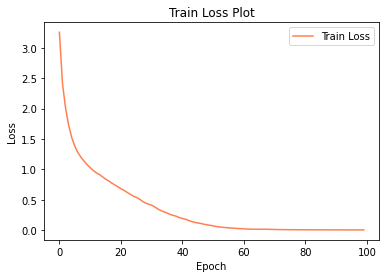

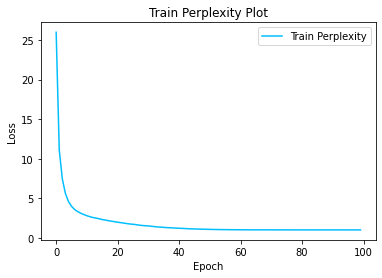

In [26]:
trump_samples = ['Good morning America', 'Very good', 'Donald Trump:']
PATH = bonus_path
trainer = Trainer(model_parameters = model_parameters, path = PATH, bptt_len = BPTT_LEN, samples = trump_samples)
counter(PATH)
print("Vocab Count: ", len(trainer.train_field.vocab))
print("Count: ", len(trainer.bptt_iterator))
trump_model = trainer.train_model(num_epochs=100)
torch.save(trump_model.state_dict(), 'trump_model.pt')

# Load Fable and Trump models

In [ ]:
# Fable Model
PATH = book_path
fable_trainer = Trainer(model_parameters = model_parameters, path = PATH, bptt_len = BPTT_LEN, samples = fable_samples)
fable_model = fable_trainer.model
fable_model.load_state_dict(torch.load('fable_model.pt'))

# Trump Model
PATH = bonus_path
trump_trainer = Trainer(model_parameters = model_parameters, path = PATH, bptt_len = BPTT_LEN, samples = fable_samples)
trump_model = trump_trainer.model
trump_model.load_state_dict(torch.load('trump_model.pt'))


# Greedy decoding for the fable model

In [36]:
#Greedy
prompt = 'THE FOX AND THE LION'
gen_text = trainer.predict(fable_model,prompt,300)
print("Greedy Decoding")
print("A title in the book")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')

#A title which you invent, which is not in the book, but similar in the style.
prompt = 'THE TURTLE AND THE BIRD'
gen_text = trainer.predict(fable_model,prompt,300)
print("A title in similar style")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
# Some texts in a similar style.
print("Some texts in similar style")
prompt = 'Back in my day'
gen_text = trainer.predict(fable_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Anything you might find interesting
print("Anything Interesting")
prompt = 'Dallmayr to go'
gen_text = trainer.predict(fable_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'Covid-19 is'
gen_text = trainer.predict(fable_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Multinomial
print("Random Decoding")
print("A title in the book")
prompt = 'THE FOX AND THE LION'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#A title which you invent, which is not in the book, but similar in the style.
print("A title in similar style")
prompt = 'THE TURTLE AND THE BIRD'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
# Some texts in a similar style.
print("Some texts in similar style")
prompt = 'Back in my day'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Anything you might find interesting
print("Anything Interesting")
prompt = 'Dallmayr to go'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'Covid-19 is'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'The Angry Turtle was'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')

#Greedy
print("Greedy Decoding")

prompt = ' '
gen_text = trainer.predict(fable_model,prompt,300)
print("A title in the book")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#A title which you invent, which is not in the book, but similar in the style.
prompt = 'A very nice day'
gen_text = trainer.predict(fable_model,prompt,300)
print("A title in similar style")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
# Some texts in a similar style.
prompt = 'I once was'
gen_text = trainer.predict(fable_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Anything you might find interesting
print("Anything Interesting")
prompt = 'Birds are flying'
gen_text = trainer.predict(fable_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'Coca Cola'
gen_text = trainer.predict(fable_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Multinomial





Greedy Decoding
A title in the book
Sample prompt: THE FOX AND THE LION | generated text: <eos><eos>A LITTLE fox was out playing one day, when a Lion came roaring along.<eos>“Dear me,” said the Fox, as he hid behind a tree, “I never saw a Lion<eos>before. What a terrible creature! His voice makes me tremble.”<eos><eos>The next time the Fox met the Lion he was not so much afraid, but he<eos>kept a safe distance and 
A title in similar style
Sample prompt: THE TURTLE AND THE BIRD | generated text: <eos><eos><eos>A WOLF, passing by, saw some Shepherds in a hut, eating for their<eos>dinner a haunch of mutton. Approaching them, he said: “Ah! gentlemen,<eos>you are feasting on mutton. I like your taste. But what a hue and cry<eos>you would raise if _I_ were to do it.”<eos><eos><eos><eos><eos>THE BOY AND THE NETTLE<eos><eos><eos>A BOY was once stung by
Some texts in similar style
Sample prompt: Back in my day | generated text:  The eggs were large, and<eos>sold for a good price. The Woman oft

# Random decoding for the fable model

In [28]:
print("Random Decoding")
prompt = ' '
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#A title which you invent, which is not in the book, but similar in the style.
prompt = 'A very nice day'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
# Some texts in a similar style.
prompt = 'I once was'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Anything you might find interesting"
print("Anything Interesting")
prompt = 'Birds are flying'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'Coca Cola'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'The Fox'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')

prompt = 'The Angry Turtle was'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')



Random Decoding
Sample prompt:   | generated text: nr.n, a Juhhreh stood up aid sard, W1rhs, I drmmeh yrtn cou<eos>ynollcb vnehe rs io gatehral moh hesrstai.e e7ual to a .okehriw om<eos>nrdes, aid iotnriw ri tne pheseit .ase so wood as leatnehb0<eos><eos>     q       q       q<eos><eos>:kehc gai moh nrs oyi thadeb<eos><eos><eos><eos><eos>vA: ATB:1 T)D vA: 2B(M1<eos><eos><eos>I) T 2(B:1v, deep, snadc, aid
Sample prompt: A very nice day | generated text: ed, tne Jo.’, as usual, fewai to .hoyb<eos><eos>T 2o4, neahriw tne souid aid tnri’riw ne yas suhe om a wood fhea’mast,<eos>.age aid stood uideh tne fhai.nesb WMood gohiriw,0 sard ne to tne Jo.’b<eos><eos>WAoy wlad I ag to ga’e tne a4 ri nrs goutn5 aid neh srstehdc .ogplcriw<eos>yrtn tnese mell rito tne yateh aid<eos>tnus ga’e 
Sample prompt: I once was | generated text: eied fc tne eitheated tnrs<eos>theatgeit, a..used nrg om rgpretc aid, ri sprte om nrs sa.hed .naha.teh<eos>as agfassadoh, e4e.uted nrg as a puflr. .hrgrialb 3ut tne 3rhds

# Greedy decoding for the trump model

In [29]:
#Greedy
prompt = 'Thank You'
gen_text = trainer.predict(trump_model,prompt,300)
print("Greedy Decoding")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#A title which you invent, which is not in the book, but similar in the style.
prompt = 'Good'
gen_text = trainer.predict(trump_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
# Some texts in a similar style.
prompt = 'China'
gen_text = trainer.predict(trump_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Anything you might find interesting
prompt = 'We have to'
gen_text = trainer.predict(trump_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')


Greedy Decoding
Sample prompt: Thank You | generated text:  he’s going to introduce people to who? To his fantastic. She is my favorite Senator from the State of Nebraska, by far, by far. She’s fantastic. She is. I’ll tell you what she calls me, it doesn’t stop. Between her and Joni Ernst from Iowa, who I think is here, where’s Joni? Joni. Joni. They call, 
Sample prompt: Good | generated text:  You lost 27 First Lady, it’s true, they love her. She’s doing a good job. They love … the whole family back there, they love that family back there. Great family, hi, Tiffany. So, Melania has it but she knocked it out pretty good. And I did a great job. I was surrounded by these doctors, 12 doctors
Sample prompt: China | generated text: into the World Trade Organization, which you supported, extending most favored nation status to China, which you supported, those steps allowed China to take advantage of the United States by using our own open trade deals against us.<eos><eos>Joe Biden: (22:45)

# Random decoding for the trump model

In [30]:
print("Random Decoding")
prompt = 'Thank You'
gen_text = trainer.predict(trump_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#A title which you invent, which is not in the book, but similar in the style.
prompt = 'Good'
gen_text = trainer.predict(trump_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
# Some texts in a similar style.
prompt = 'China'
gen_text = trainer.predict(trump_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Anything you might find interesting
prompt = 'We have to'
gen_text = trainer.predict(trump_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = ' '
gen_text = trainer.predict(trump_model,prompt,1000,method="greedy")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = ' '
gen_text = trainer.predict(trump_model,prompt,1000,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
print("Something not in the text")

Random Decoding
Sample prompt: Thank You | generated text:  he’s going to introduce people to who’s fine higher. Wis corn it a few and we can talk about the way that was the state of Michigan, and we’re going to win four more years in the White House. By the way, there has never been a campaign …<eos><eos>Donald Trump: (08:47)<eos>There has never been a campaign, in th
Sample prompt: Good | generated text:  You know, I have a lot of my kids here tonight. Could you imagine if my kids said, “Yeah, dad, I got a billion and a half dollars from China.” Oh, I don’t think they’d want to write about that, the fake news. Do you think they’d write about that? Then he gets three and a half million dollars from t
Sample prompt: China | generated text: is not like that. President Putin of Russia. There’s nobody been tougher than Russia. And I hope you can hear. Can you hear it back there by the way?<eos><eos>Audience: (03:33:31)<eos>No!<eos><eos>President Donald J. Trump: (03:34)<eos>Yes, no?<eos><

# Comparing random and greedy for both models

In [32]:

print("Random Decoding")
prompt = 'Birds fly high'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'Birds fly high'
print("Greedy Decoding")
gen_text = trainer.predict(fable_model,prompt,300,method="greedy")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = '<eos>'
gen_text = trainer.predict(fable_model,prompt,600,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
gen_text = trainer.predict(fable_model,prompt,600,method="greedy")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')

prompt = 'THE WOLF AND THE LAMB'
gen_text = trainer.predict(fable_model,prompt,1000,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'THE WOLF AND THE LAMB'
gen_text = trainer.predict(fable_model,prompt,1000,method="greedy")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')


print("Greedy Decoding")
prompt = "President Donald J. Trump: "
gen_text = trainer.predict(trump_model,prompt,600,method="greedy")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
print("Random Decoding")
prompt = "President Donald J. Trump: "
gen_text = trainer.predict(trump_model,prompt,600,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')

Random Decoding
Sample prompt: Birds fly high | generated text: tnriw tnat rt yas<eos>so wood as aiotneh, a pehme.t gahkelb (ilc oie tnriw<eos>rs uilu.’c[tne 17urhhel nas loiw awo lost all nrs teetnb<eos><eos><eos><eos><eos>vA: ?(S2 T)D vA: JTv<eos><eos><eos>T ?(S2 hai out om tne mohest rito a krllawe[iot to pac a krsrt, fut to<eos>sake rts lrme5 moh rt thegfled moh rts s’rib<eos><eos>vne nuitsgai aid a pa.’ om n
Greedy Decoding
Sample prompt: Birds fly high | generated text: l ri aid ri daiweh mhog tne wheat<eos>.lugsc .heatuhe, .alled out, WAelp” nelp”0 aid tne sehkaits, huiiriw<eos>ri, dhoke tne Doi’ec out om doohs yrtn str.’s aid stoiesb<eos><eos><eos><eos><eos>vA: ():“:N:D D(:<eos><eos><eos>T D(:, flrid ri oie ece, used to wha-e as ieah as sne .ould to tne edwe<eos>om a .lrmm, so tnat sne grwnt ’eep neh flrid
Sample prompt: <eos> | generated text: 3hoyi“f<eos><eos>    vne vhugpeteh tnat tne HhoYe.t Muteifehw Srtehahc Th.nrke 2ouidatroi rs a ioi phomrt<eos>ULCR.8R68 edu.atroial .oh